<a href="https://colab.research.google.com/github/gamsingh/CS7643/blob/main/Pollution_Data_Connect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Pollution Forecasting

Dataset: Air Quality Data from UCI

Problem: Forecast pollution levels based on historical data from multiple sensors.

Use Case: Environmental monitoring, urban planning, and public health.
Dataset Size: Several thousand instances of hourly averaged responses from an array of sensors.

Convolutional LSTM Application: Used to model the temporal sequences of pollution levels while considering the spatial layout of the sensor grid.


# Research Papers

## A Hybrid CNN-LSTM Model for Forecasting Particulate Matter (PM2.5)

Summary: This paper introduces a hybrid model combining convolutional layers with LSTM cells for forecasting PM2.5 concentrations. The model captures spatial dependencies using convolutional layers and temporal dependencies using LSTM cells.

Link: https://ieeexplore.ieee.org/document/8979420

## Spatio-temporal fusion of meteorological factors for multi-site PM2.5 prediction: A deep learning and time-variant graph approach

Summary: This work uses a Convolutional LSTM network to predict pollution levels by incorporating spatial features (from nearby sensors) and temporal features (time-series data).

Link: https://www.sciencedirect.com/science/article/pii/S001393512302090X

# Dataset

## EPA Air Quality System (AQS) Data Mart
Link: EPA AQS Data Mart
Description: Provides access to air quality monitoring data from various locations in the United States, including pollutants like PM2.5, ozone, and NO2. You can download historical data for multiple monitoring stations.

https://www.epa.gov/outdoor-air-quality-data


## OpenAQ Platform
Link: OpenAQ Air Quality Data
Description: A global platform offering access to air quality data from multiple countries. Data can be accessed through their API, and it includes spatio-temporal measurements of pollutants like PM2.5 and PM10.

https://docs.openaq.org/using-the-api/geospatial



In [ ]:
import requests
import pandas as pd

# API key and headers
api_key = '6701a271856184c8160a38297861c796ac408e69ca7be88c9f358a122bc2378a'
headers = {
    'x-api-key': api_key
}

# Define the API endpoint and parameters
url = 'https://api.openaq.org/v2/measurements'
params = {
    'city': 'Los Angeles',
    'parameter': 'pm25',
    'limit': 10000,  # Maximum number of records to retrieve
    'date_from': '2022-01-01T00:00:00+00:00',
    'date_to': '2022-12-31T23:59:59+00:00',
    'format': 'json'
}

# Fetch data using the API
response = requests.get(url, headers=headers, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()['results']
    print("Data successfully fetched!")
else:
    print("Error fetching data:", response.status_code)
    data = []

# Convert the JSON data to a Pandas DataFrame
# df = pd.DataFrame(data)

# df.head()

df = pd.DataFrame(data)

# Convert 'date.utc' to a datetime object and extract 'latitude' and 'longitude' from the 'coordinates' field
df['date'] = pd.to_datetime(df['date'].apply(lambda x: x['utc']))
df['latitude'] = df['coordinates'].apply(lambda x: x['latitude'] if x else None)
df['longitude'] = df['coordinates'].apply(lambda x: x['longitude'] if x else None)

df.head()

Data successfully fetched!


,locationId,location,parameter,value,date,unit,coordinates,country,city,isMobile,isAnalysis,entity,sensorType,latitude,longitude
0,270,Los Ángeles Oriente,pm25,23.0,2022-12-31 23:00:00+00:00,µg/m³,"{'latitude': -37.463035064801, 'longitude': -7...",CL,None,False,None,Governmental Organization,reference grade,-37.463035,-72.324575
1,270,Los Ángeles Oriente,pm25,23.0,2022-12-31 22:00:00+00:00,µg/m³,"{'latitude': -37.463035064801, 'longitude': -7...",CL,None,False,None,Governmental Organization,reference grade,-37.463035,-72.324575
2,270,Los Ángeles Oriente,pm25,23.0,2022-12-31 21:00:00+00:00,µg/m³,"{'latitude': -37.463035064801, 'longitude': -7...",CL,None,False,None,Governmental Organization,reference grade,-37.463035,-72.324575
3,270,Los Ángeles Oriente,pm25,22.0,2022-12-31 20:00:00+00:00,µg/m³,"{'latitude': -37.463035064801, 'longitude': -7...",CL,None,False,None,Governmental Organization,reference grade,-37.463035,-72.324575
4,270,Los Ángeles Oriente,pm25,21.0,2022-12-31 19:00:00+00:00,µg/m³,"{'latitude': -37.463035064801, 'longitude': -7...",CL,None,False,None,Governmental Organization,reference grade,-37.463035,-72.324575


In [ ]:
# Display basic information about the dataset
print(df.info())

# Show summary statistics
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   locationId   10000 non-null  int64              
 1   location     10000 non-null  object             
 2   parameter    10000 non-null  object             
 3   value        10000 non-null  float64            
 4   date         10000 non-null  datetime64[ns, UTC]
 5   unit         10000 non-null  object             
 6   coordinates  10000 non-null  object             
 7   country      10000 non-null  object             
 8   city         0 non-null      object             
 9   isMobile     10000 non-null  bool               
 10  isAnalysis   0 non-null      object             
 11  entity       10000 non-null  object             
 12  sensorType   10000 non-null  object             
 13  latitude     10000 non-null  float64            
 14  longitude    10000 non-

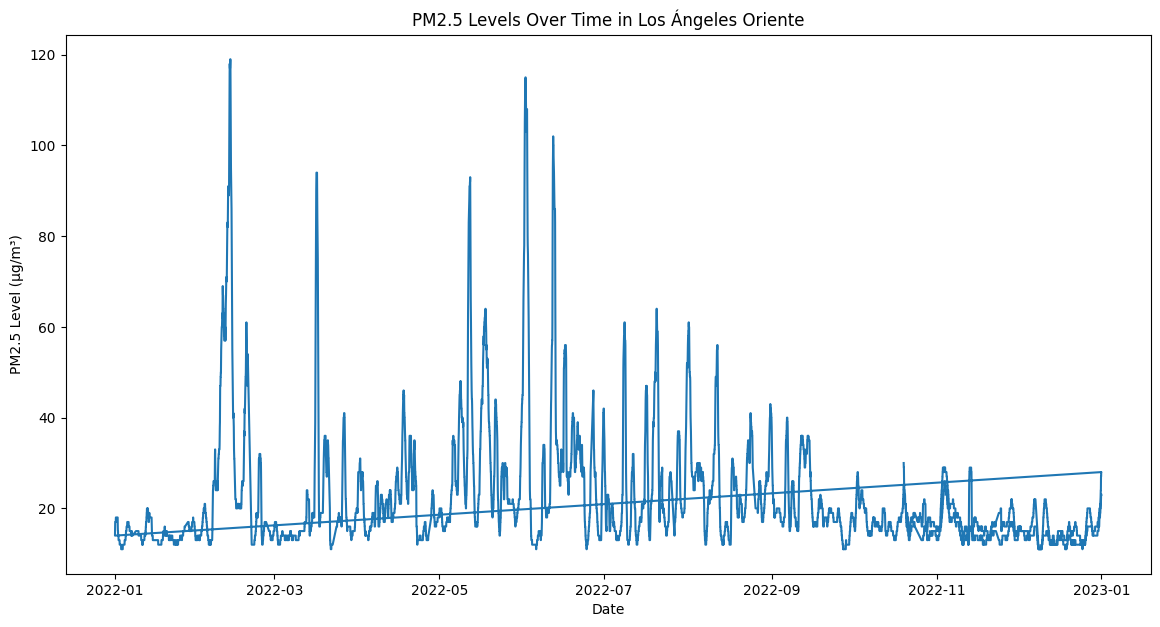

In [ ]:
import matplotlib.pyplot as plt

# Plot PM2.5 levels over time for the entire dataset
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['value'])
plt.xlabel('Date')
plt.ylabel('PM2.5 Level (µg/m³)')
plt.title('PM2.5 Levels Over Time in Los Ángeles Oriente')
plt.show()


In [ ]:
# Fetch PM2.5 and meteorological data
def fetch_data(city, parameter, start_date, end_date):
    url = 'https://api.openaq.org/v2/measurements'
    params = {
        'city': city,
        'parameter': parameter,
        'date_from': start_date,
        'date_to': end_date,
        'limit': 10000,
        'format': 'json'
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return pd.DataFrame(response.json()['results'])
    else:
        print(f"Error: {response.status_code}")
        return pd.DataFrame()

pm25_df = fetch_data('Los Angeles', 'pm25', '2022-01-01', '2022-12-31')
temperature_df = fetch_data('Los Angeles', 'temperature', '2022-01-01', '2022-12-31')
humidity_df = fetch_data('Los Angeles', 'humidity', '2022-01-01', '2022-12-31')


In [ ]:
pm25_df

,locationId,location,parameter,value,date,unit,coordinates,country,city,isMobile,isAnalysis,entity,sensorType
0,270,Los Ángeles Oriente,pm25,16.0,"{'utc': '2022-12-31T00:00:00+00:00', 'local': ...",µg/m³,"{'latitude': -37.463035064801, 'longitude': -7...",CL,None,False,None,Governmental Organization,reference grade
1,270,Los Ángeles Oriente,pm25,16.0,"{'utc': '2022-12-30T23:00:00+00:00', 'local': ...",µg/m³,"{'latitude': -37.463035064801, 'longitude': -7...",CL,None,False,None,Governmental Organization,reference grade
2,270,Los Ángeles Oriente,pm25,15.0,"{'utc': '2022-12-30T22:00:00+00:00', 'local': ...",µg/m³,"{'latitude': -37.463035064801, 'longitude': -7...",CL,None,False,None,Governmental Organization,reference grade
3,270,Los Ángeles Oriente,pm25,15.0,"{'utc': '2022-12-30T21:00:00+00:00', 'local': ...",µg/m³,"{'latitude': -37.463035064801, 'longitude': -7...",CL,None,False,None,Governmental Organization,reference grade
4,270,Los Ángeles Oriente,pm25,15.0,"{'utc': '2022-12-30T20:00:00+00:00', 'local': ...",µg/m³,"{'latitude': -37.463035064801, 'longitude': -7...",CL,None,False,None,Governmental Organization,reference grade
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2334,21 de mayo,pm25,22.0,"{'utc': '2022-10-18T02:00:00+00:00', 'local': ...",µg/m³,"{'latitude': -37.471182288689, 'longitude': -7...",CL,None,False,None,Governmental Organization,reference grade
9996,2334,21 de mayo,pm25,22.0,"{'utc': '2022-10-18T01:00:00+00:00', 'local': ...",µg/m³,"{'latitude': -37.471182288689, 'longitude': -7...",CL,None,False,None,Governmental Organization,reference grade
9997,2334,21 de mayo,pm25,22.0,"{'utc': '2022-10-18T00:00:00+00:00', 'local': ...",µg/m³,"{'latitude': -37.471182288689, 'longitude': -7...",CL,None,False,None,Governmental Organization,reference grade
9998,2334,21 de mayo,pm25,22.0,"{'utc': '2022-10-17T23:00:00+00:00', 'local': ...",µg/m³,"{'latitude': -37.471182288689, 'longitude': -7...",CL,None,False,None,Governmental Organization,reference grade


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(df, parameter):
    df['date'] = pd.to_datetime(df['date'].apply(lambda x: x['utc']))
    df = df[['date', 'value', 'location', 'coordinates']]
    df = df.rename(columns={'value': parameter})
    df['latitude'] = df['coordinates'].apply(lambda x: x['latitude'] if x else None)
    df['longitude'] = df['coordinates'].apply(lambda x: x['longitude'] if x else None)
    return df.drop(columns=['coordinates'])

# Preprocess each dataset
pm25_df = preprocess_data(pm25_df, 'pm25')
temperature_df = preprocess_data(temperature_df, 'temperature')
humidity_df = preprocess_data(humidity_df, 'humidity')

# Merge data based on date and location
merged_df = pd.merge(pm25_df, temperature_df, on=['date', 'location'], how='inner')
merged_df = pd.merge(merged_df, humidity_df, on=['date', 'location'], how='inner')

# Normalize the values
scaler = MinMaxScaler()
merged_df[['pm25', 'temperature', 'humidity']] = scaler.fit_transform(merged_df[['pm25', 'temperature', 'humidity']])


KeyError: 'date'